### Imports

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import catboost as cat

### Data view and research

In [3]:
path = '/content/drive/MyDrive/datasets/playground-series-s3e9/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
result = pd.read_csv(path + 'sample_submission.csv')

In [4]:
df_train

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...,...
5402,5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


In [5]:
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

numeric_columns = df_train.select_dtypes(include=['int','float']).columns
categorical_columns = df_train.select_dtypes(include=['object','bool','category']).columns

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_train.shape[1])

Number of numerical columns: 9
Number of categorical columns: 0
Total number of columns in the feature dataframe: 9


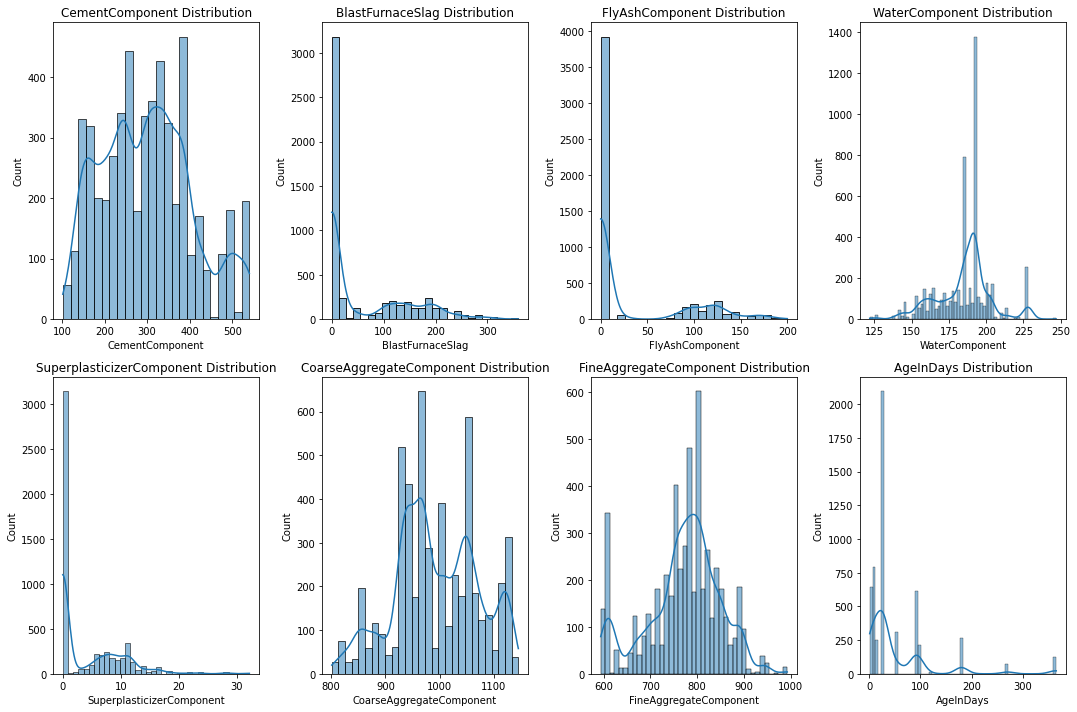

In [6]:
plt.figure(figsize=(15,10))
for id,column in enumerate(numeric_columns[:-1]):
    plt.subplot(2,4,id+1)
    sns.histplot(x=column,data=df_train, kde=True, palette="Set1")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

In [7]:
columns = ['BlastFurnaceSlag', 'SuperplasticizerComponent']

df_train.drop(['FlyAshComponent'], axis=1, inplace=True)
df_test.drop(['FlyAshComponent'], axis=1, inplace=True)
df_train[columns] = (df_train[columns] != 0.0).astype('int64')
df_train[columns] = (df_train[columns] != 0.0).astype('int64')

In [8]:
X = df_train.drop(['Strength'], axis=1)
y = df_train['Strength']
# y = np.log(y)

### Tuning and training model

In [9]:
n_estimators = 9999
use_gpu = "CUDA_VISIBLE_DEVICES" in os.environ

device = "gpu" if use_gpu else "cpu"

xgb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror'
}

lgb_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample_for_bin': 20000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'regression',
    'device': device
}

cat_params = {
    'n_estimators': n_estimators,
    'learning_rate': 0.05,
    'max_depth': 8,
    'loss_function': 'RMSE',
    'task_type': device.upper()
}

In [10]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
pred_xgb = np.zeros(df_test.shape[0])
pred_cat = np.zeros(df_test.shape[0])
pred_lgb = np.zeros(df_test.shape[0])
rmse_xgb=[]  
rmse_cat=[]
rmse_lgb=[]
rmse = []
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    
    # XGBoost regressor
    model_xgb = XGBRegressor(**xgb_params)
    model_xgb.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],early_stopping_rounds=100,verbose=False) 
    pred_xgb+=model_xgb.predict(df_test)/kfold.n_splits
    rmse_xgb.append(mean_squared_error(y_valid, model_xgb.predict(X_valid), squared=False))
    
    # CatBoost regressor
    model_cat = cat.CatBoostRegressor(**cat_params)
    model_cat.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],early_stopping_rounds=100,verbose=False) 
    pred_cat+=model_cat.predict(df_test)/kfold.n_splits
    rmse_cat.append(mean_squared_error(y_valid, model_cat.predict(X_valid), squared=False))
    
    # LightGBM regressor
    model_lgb = LGBMRegressor(**lgb_params)
    model_lgb.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],early_stopping_rounds=100,verbose=False) 
    pred_lgb+=model_lgb.predict(df_test)/kfold.n_splits
    rmse_lgb.append(mean_squared_error(y_valid, model_lgb.predict(X_valid), squared=False))
    
    rmse_val = (rmse_xgb[n]+ rmse_cat[n]+ rmse_lgb[n]) / 3    
    rmse.append(rmse_val)
    print(f"fold: {n+1} ==> rmse: {rmse[n]} (xgb: {rmse_xgb[n]}, cat: {rmse_cat[n]}, lgb: {rmse_lgb[n]})")
    n += 1

print(np.mean(rmse))

fold: 1 ==> rmse: 11.67463476310085 (xgb: 11.845932390049677, cat: 11.643772561283763, lgb: 11.534199337969113)
fold: 2 ==> rmse: 12.738175281652742 (xgb: 13.049595801924776, cat: 12.587141262843524, lgb: 12.577788780189925)
fold: 3 ==> rmse: 11.635325182893098 (xgb: 12.046270946875081, cat: 11.329845422262087, lgb: 11.529859179542127)
fold: 4 ==> rmse: 12.878477076735905 (xgb: 13.101172891343117, cat: 12.819622185204365, lgb: 12.714636153660233)
fold: 5 ==> rmse: 12.749438957385571 (xgb: 13.080762230000005, cat: 12.504226148231153, lgb: 12.663328493925555)
fold: 6 ==> rmse: 11.695012001749037 (xgb: 11.833660841345647, cat: 11.632880327119109, lgb: 11.618494836782356)
fold: 7 ==> rmse: 12.761900040933014 (xgb: 13.035631654358822, cat: 12.568000369772944, lgb: 12.682068098667273)
fold: 8 ==> rmse: 12.015102983887417 (xgb: 12.25008818831884, cat: 11.878582771507288, lgb: 11.916637991836122)
fold: 9 ==> rmse: 11.790744729291168 (xgb: 12.129051795841356, cat: 11.60673283398286, lgb: 11.636

### Final submission

In [11]:
# pred_xgb = np.exp(pred_xgb)
# pred_cat = np.exp(pred_cat)
# pred_lgb = np.exp(pred_lgb)

In [12]:
result['Strength'] = (pred_cat)
result.to_csv('submission.csv', index=False)
result

,id,Strength
0,5407,49.701231
1,5408,19.690236
2,5409,34.311356
3,5410,47.819786
4,5411,36.199654
...,...,...
3600,9007,34.194451
3601,9008,36.045145
3602,9009,40.988133
3603,9010,33.731076
